In [50]:
import os
import glob
import shutil
import numpy as np
import random
import matplotlib.pyplot as plt

In [51]:
import sys
sys.path.insert(1, os.path.join(sys.path[0], '../'))

In [52]:
import utils

In [53]:
# Define dataset.
dataset_name = 'fashion_mnist'
# dataset_name = 'cifar_10'
# dataset_name = 'svhn'

dataset_dir = '../datasets/' + dataset_name
train_dir = os.path.join(dataset_dir, 'train')
class_labels = os.listdir(train_dir)
class_labels.sort()
print(class_labels)

['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt top', 'Trouser']


In [54]:
# Read image list into a dictionary for each class.
train_img_dict = {}
for class_label in class_labels:
    class_folder = os.path.join(train_dir, class_label)
    img_list = glob.glob(os.path.join(class_folder, '*.JPG')) + glob.glob(os.path.join(class_folder, '*.jpg')) + glob.glob(os.path.join(class_folder, '*.png'))           
    train_img_dict[class_label] = img_list
    print(class_label, ':', len(img_list))

Ankle boot : 6000
Bag : 6000
Coat : 6000
Dress : 6000
Pullover : 6000
Sandal : 6000
Shirt : 6000
Sneaker : 6000
T-shirt top : 6000
Trouser : 6000


In [55]:
def get_dirichlet_proportions(beta, num_clients, num_total_samples):
    rng = np.random.default_rng()
    proportions = rng.dirichlet(np.repeat(beta, num_clients))
    proportions = proportions / proportions.sum()
    proportions = np.round(proportions * num_total_samples).astype(int)[:-1]
    proportions = np.append(proportions, max(0, num_total_samples - sum(proportions)))           # For the last client.
    return proportions

In [56]:
# Define distribution settings.
num_clients = 12
beta = 0.1 # [0.1, 0.5, 5]

client_data_dir = os.path.join('./client_data/', dataset_name + '_beta_{}'.format(beta))

In [57]:
data_notes = {}

for class_label in class_labels:

    sample_list = train_img_dict[class_label]
    random.shuffle(sample_list)
    num_total_samples = len(sample_list)
    
    proportions = get_dirichlet_proportions(beta, num_clients, num_total_samples)
    print('{:>12} : {}'.format(class_label, proportions))
    
    start_idx = 0
    for client_idx in range(num_clients):
        end_idx = start_idx + proportions[client_idx]
        dest_dir = os.path.join(client_data_dir, str(client_idx), class_label)
        os.makedirs(dest_dir)
        for img in sample_list[start_idx:end_idx]:
            shutil.copy(img, dest_dir)
        start_idx = end_idx
        data_notes.setdefault(client_idx, {})
        data_notes[client_idx][class_label] = proportions[client_idx]

  Ankle boot : [ 215 1221 2977    0    0   15    0 1572    0    0    0    0]
         Bag : [   0   47  583    0    0    0  896    0    0    0  287 4187]
        Coat : [   1    3    0  675    0    0 4694   45    0  366  160   56]
       Dress : [   0    0    4    0    0    0 5254  231    0   86    0  425]
    Pullover : [   0    0    0    0  556  799   21 1153  532 2913   26    0]
      Sandal : [  15   24   24  599   91    0   10    0   11 5225    0    1]
       Shirt : [   2  939    0 1877    1 3139    0    1   29    0   11    1]
     Sneaker : [4151    0 1240    0   16   18    9    0    1   78  221  266]
 T-shirt top : [   0  355 1106    0    0 4515    0    6    0   16    0    2]
     Trouser : [ 164  848 1342 1065    6    0    1 1850  382   13  167  162]


In [58]:
for client_idx in range(num_clients):
    note_file = os.path.join(os.path.join(client_data_dir, str(client_idx), 'notes.txt'))
    txt = ''
    for class_label, num_samples in data_notes[client_idx].items():
        buff = '{:15} : {}\n'.format(class_label, num_samples)
        txt += buff
    utils.save_notes(note_file, txt)

In [59]:
mat = np.zeros((num_clients, len(class_labels)))

x, y, n = [], [], []
for idx in range(num_clients):
    client_dir = os.path.join(client_data_dir, str(idx))
    for class_idx, label in enumerate(class_labels):
        class_dir = os.path.join(client_dir, label)
        if os.path.exists(class_dir):
            n.append((1*len(os.listdir(class_dir)))**1)
            mat[idx][class_idx] = len(os.listdir(class_dir))
        else:
            n.append(0)
            mat[idx][class_idx] = 0
        y.append(label)
        x.append(idx)

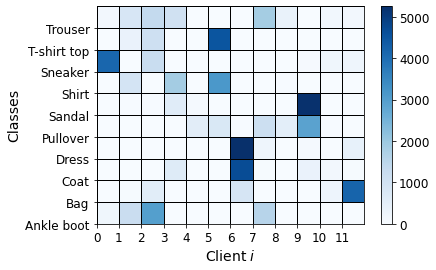

In [60]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot()

im = ax.pcolormesh(np.transpose(mat), edgecolors='k', linewidth=1, cmap=plt.get_cmap('Blues'))
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=12)

ax.set_xlabel('Client $i$', fontsize=14)
ax.set_ylabel('Classes', fontsize=14)

yticks = class_labels

ax.set_yticks(range(len(yticks)))
ax.set_yticklabels(yticks)  

ax.set_xticks(range(num_clients))

ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(labelsize=12)
plt.savefig(os.path.join(client_data_dir, 'client_data_amount.png'), dpi=300, bbox_inches='tight')
plt.show()